In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
x1 = np.linspace(0, 10, 12)
x2 = np.linspace(0, 10, 12)
xx, yy = np.meshgrid(x1, x2)
X = np.column_stack([xx.flatten(), yy.flatten()])

## Isotropic samples

### A single group

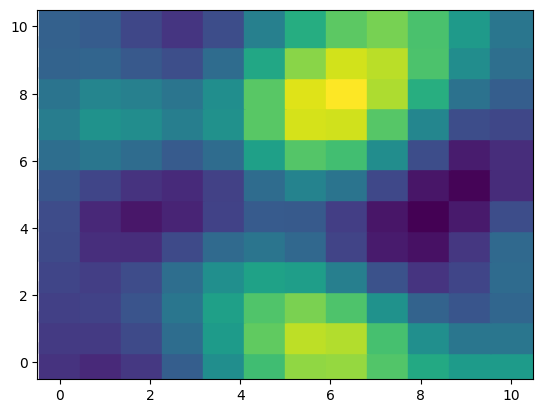

In [5]:
rng = np.random.default_rng(1234)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots()
ax.scatter(xx, yy, c=f, s=900, marker="s");

In [6]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

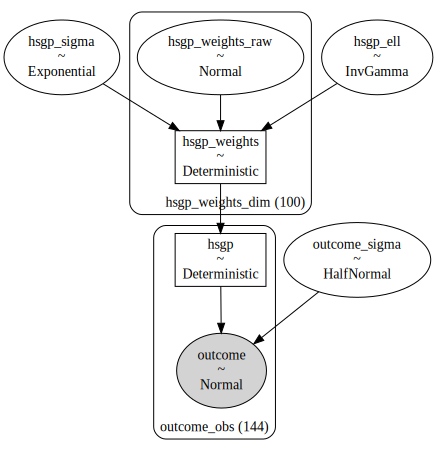

In [7]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10)": "hsgp"})
model.build()
model.graph()

In [8]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:02.593201
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:24.893673
Transforming variables...
Transformation time =  0:00:00.515905
0


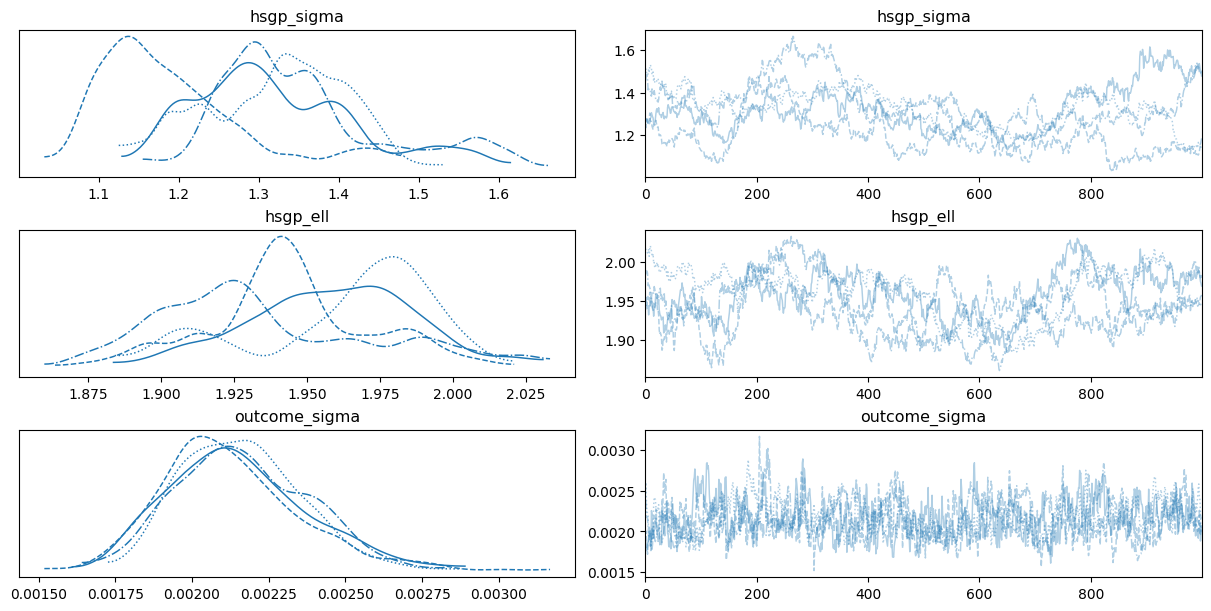

In [9]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - same covariance function

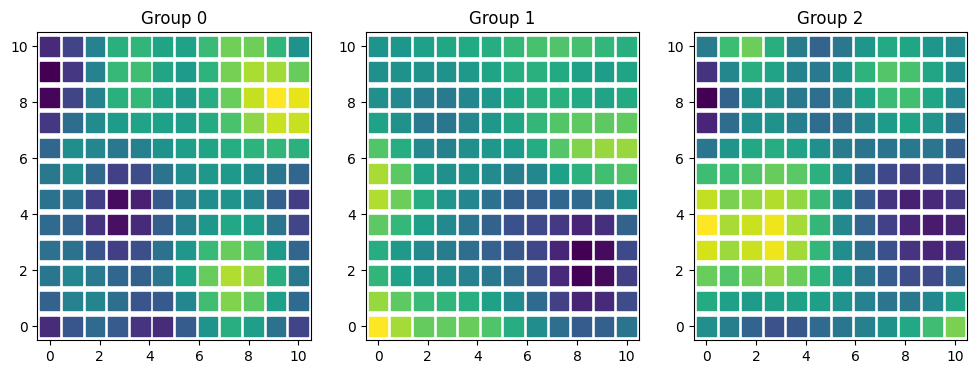

In [10]:
rng = np.random.default_rng(123)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [13]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

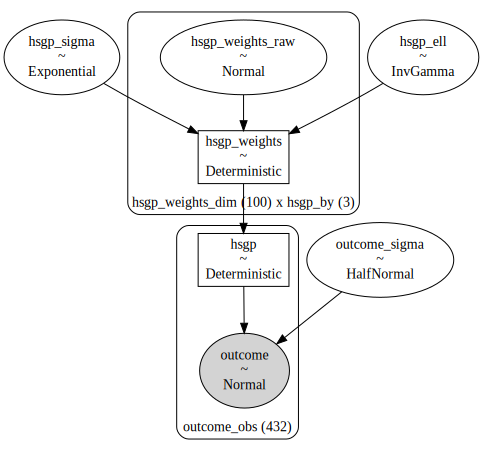

In [14]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10)": "hsgp"})
model.build()
model.graph()

In [15]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.764583
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:57.858220
Transforming variables...
Transformation time =  0:00:00.687557
0


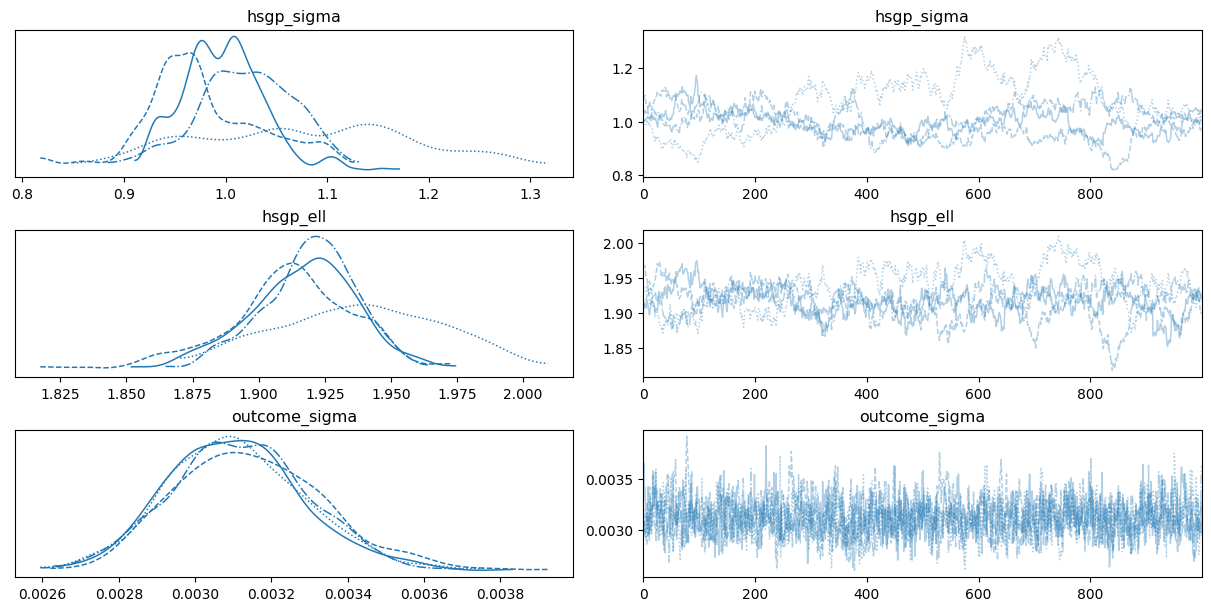

In [16]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - different covariance function

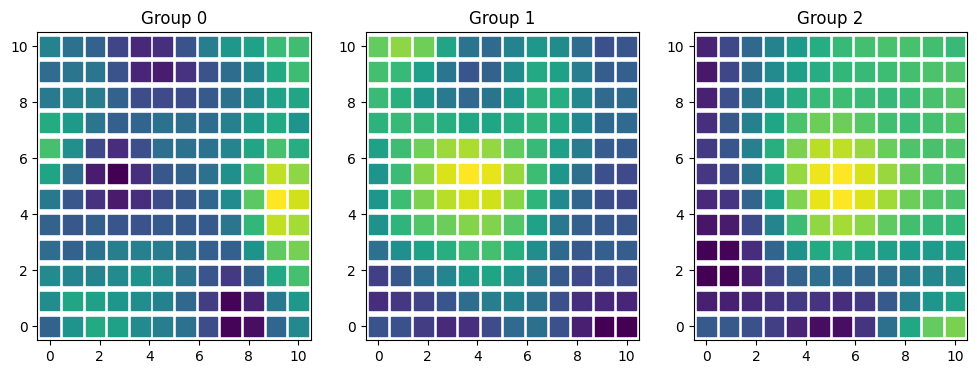

In [17]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [1.5, 2, 3]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [18]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

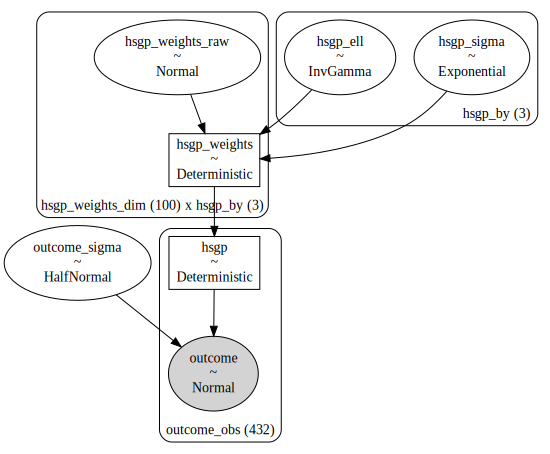

In [19]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": "hsgp"})
model.build()
model.graph()

In [20]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:03.968146
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:14.964298
Transforming variables...
Transformation time =  0:00:00.917712
0


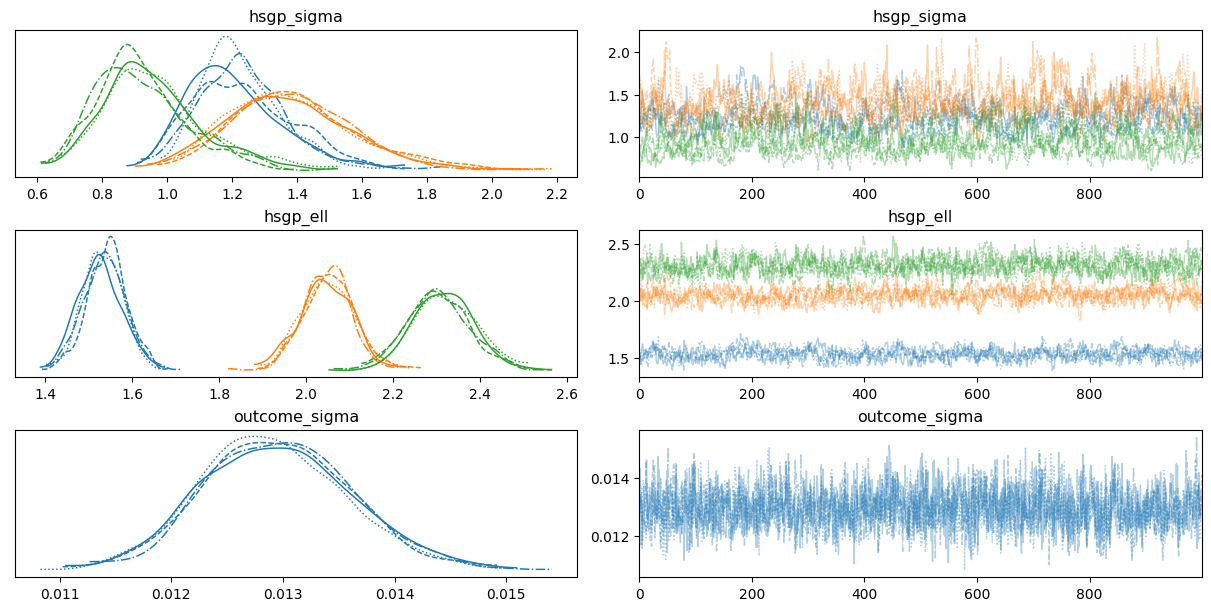

In [21]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

## Anisotropic samples

### A single group

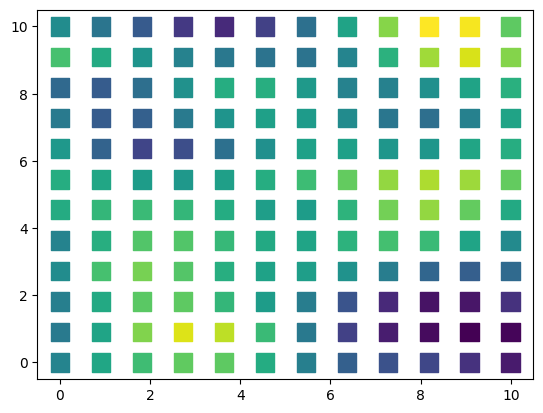

In [22]:
rng = np.random.default_rng(1234)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots()
ax.scatter(xx, yy, c=f, s=180, marker="s");

In [23]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

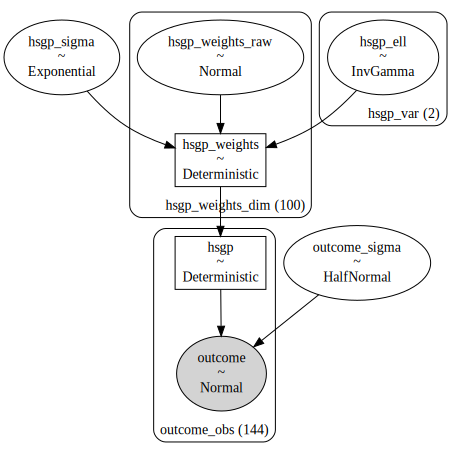

In [24]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10, iso=False)": "hsgp"})
model.build()
model.graph()

In [25]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.636281
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.379370
Transforming variables...
Transformation time =  0:00:00.195859
0


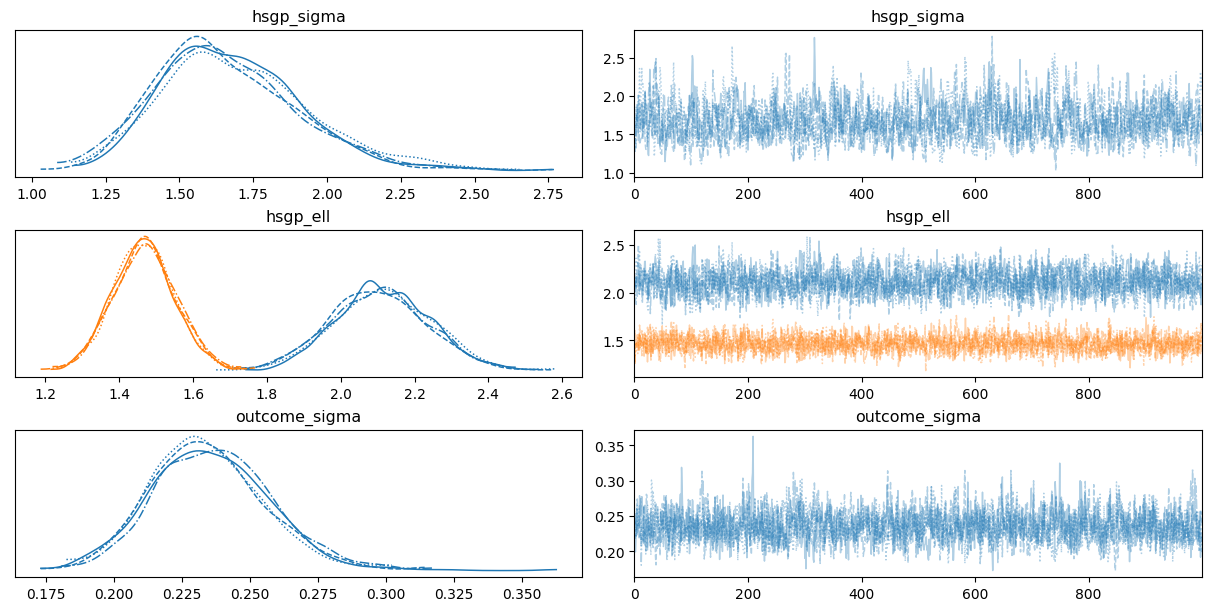

In [26]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - same covariance function

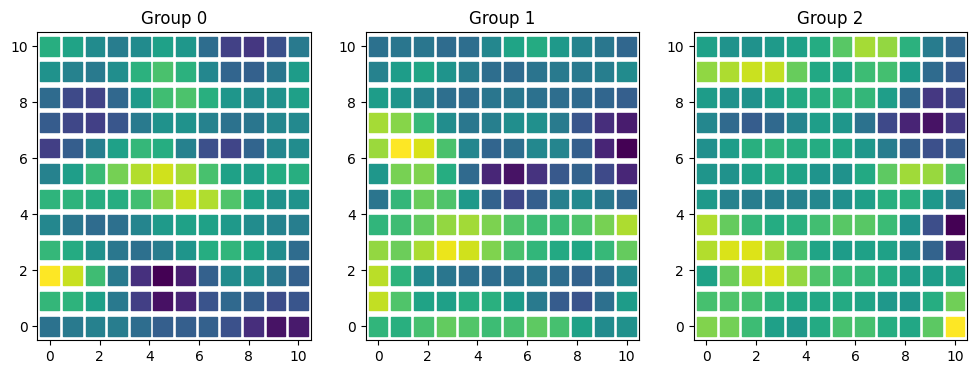

In [27]:
rng = np.random.default_rng(123)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [28]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

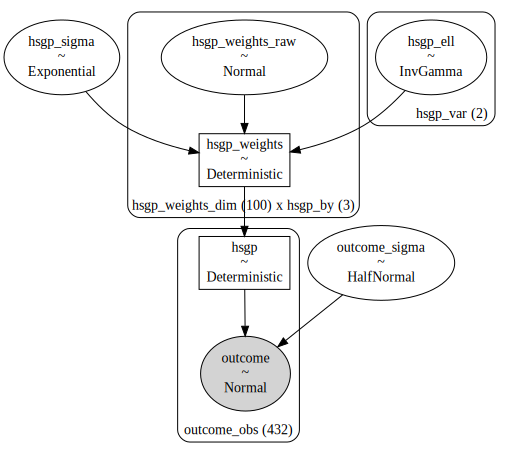

In [29]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False)": "hsgp"})
model.build()
model.graph()

In [30]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.573878
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:15.846781
Transforming variables...
Transformation time =  0:00:00.275446
0


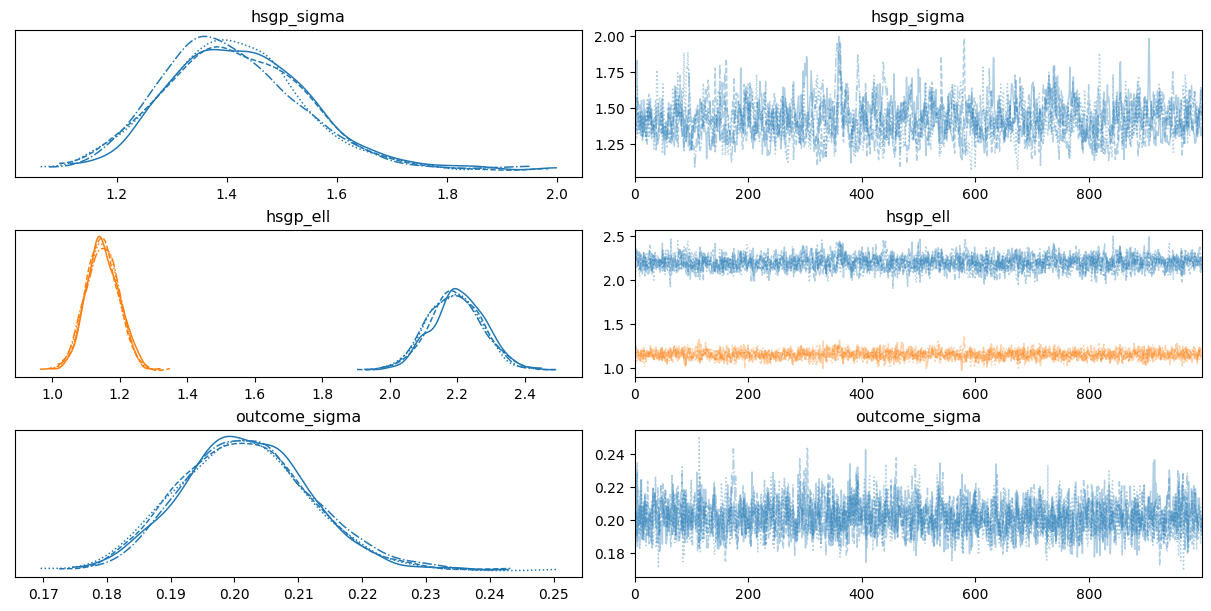

In [31]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - different covariance function

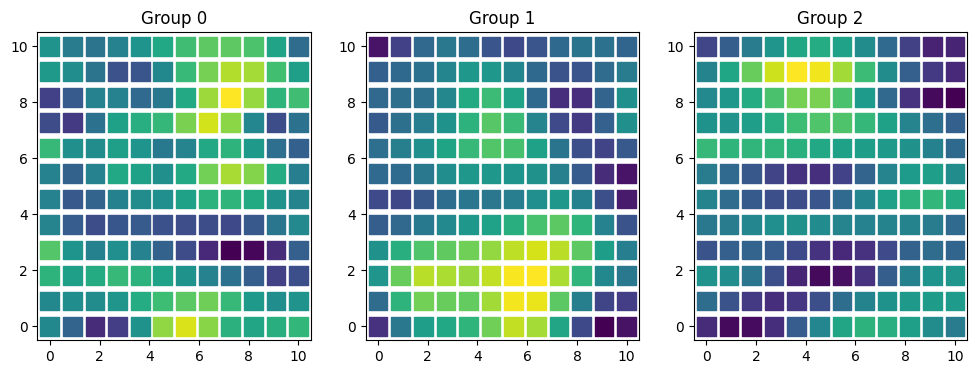

In [32]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [[1.5, 0.8], [2, 1.5], [3, 1]]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [33]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

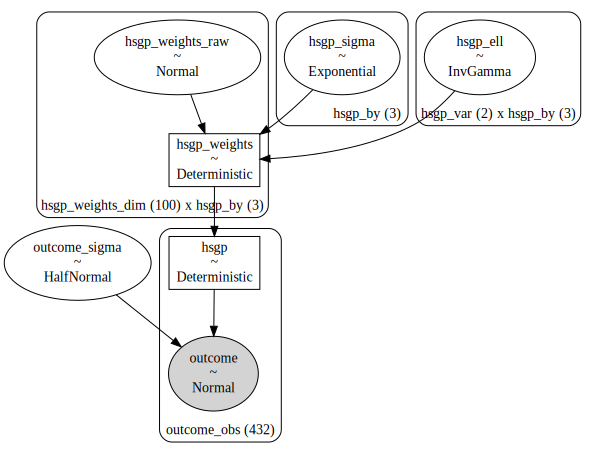

In [35]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": "hsgp"})
model.build()
model.graph()

In [36]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.134657
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:24.590216
Transforming variables...
Transformation time =  0:00:00.490450
0


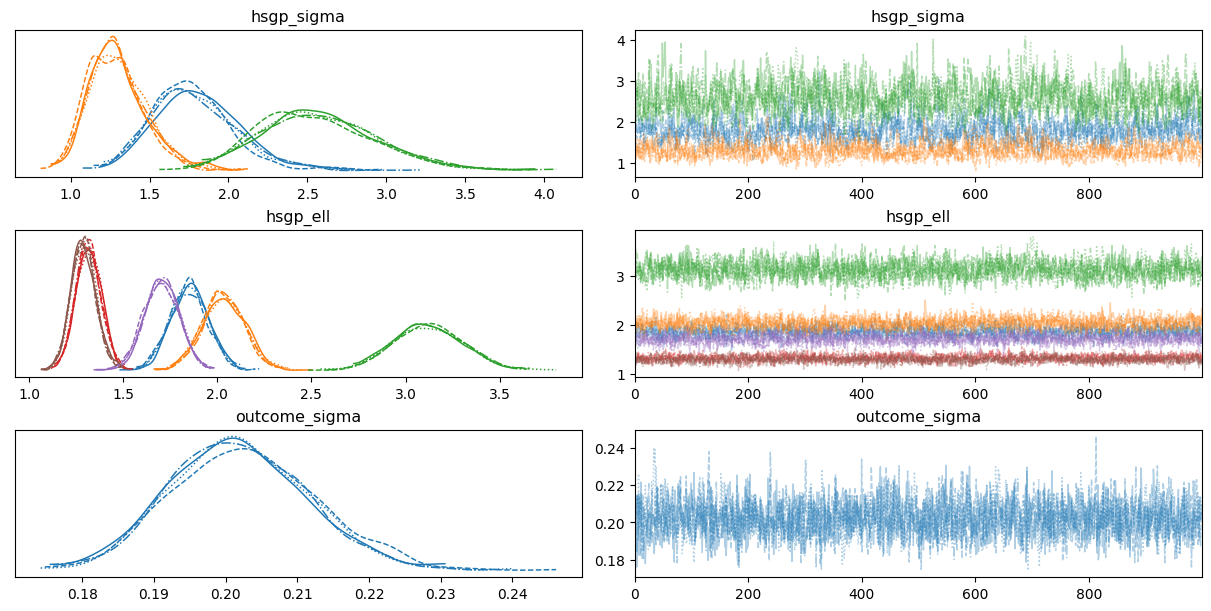

In [37]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);